In [22]:
!pip install kaggle
!kaggle datasets download -d guare13/handwritten-letters-recognition
!unzip handwritten-letters-recognition.zip

Dataset URL: https://www.kaggle.com/datasets/guare13/handwritten-letters-recognition
License(s): CC0-1.0
handwritten-letters-recognition.zip: Skipping, found more recently modified local copy (use --force to force download)
Archive:  handwritten-letters-recognition.zip
replace test_letters/letter_0.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: ^C


In [95]:
import torch
import tensorflow as tf
import os
import cv2
import imghdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import LabelBinarizer
from itertools import chain
import random
import shutil
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from PIL import Image
from torchvision import transforms
import torch.nn.functional as F

In [96]:
train = pd.read_csv('written_letters_train.csv')
validation = pd.read_csv('written_letters_validation.csv')

In [97]:
characters = sorted(set("".join(train['nombre'].astype(str))))
char_to_label = {char: idx for idx, char in enumerate(characters)}
label_to_char = {idx: char for char, idx in char_to_label.items()}

In [98]:
path_val = "valid_letters"
path_test = "test_letters"
path_train = "train_letters"

In [99]:
class DataGenerator(Dataset):
    def __init__(self, dataframe, path, char_map, img_size=(14, 10), transform=None):
        self.dataframe = dataframe
        self.path = path
        self.char_map = char_map
        self.img_size = img_size
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe['id'].values[idx]
        img = cv2.imread(os.path.join(self.path, img_path), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, self.img_size)
        img = img / 255.0
        if self.transform:
            img = self.transform(img)
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)
        
        text = str(self.dataframe['nombre'].values[idx])
        label = torch.tensor([self.char_map[char] for char in text], dtype=torch.long)
        return img, label

In [100]:
# Transformación para las imágenes
transform = transforms.Compose([
    transforms.ToTensor()
])

In [101]:
train_generator=DataGenerator(train,path_train,char_to_label)
validation_generator=DataGenerator(validation,path_val,char_to_label)

In [102]:
train_loader = DataLoader(train_generator, batch_size=128, shuffle=True)
validation_loader = DataLoader(validation_generator, batch_size=128, shuffle=False)

In [103]:
# Defineix el model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        """
        Entren imatges amb 3 canals de color (RGB) i amb aquesta capa convolucional
        s'estreuen característiques loclas de la imatge detectant patrons com bordes,
        textures i altres detalls que poden ser importants.
        """
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        """
        El max pooling redueix la dimensionalitat dels mapas de característiques,
        disminuint la mida de les imatges i retenint les característiques més importants
        Això ajuda a reduir el sobreajustament i millora l'eficàcia computacional.
        """
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        
        self.dropout = nn.Dropout(0.5)
        """
        Les següents dues capes s'ecarreguen de la classificació final. Transformen
        les característiques extretes per les capas convolucionals i de pooling a les
        propietats de les diferents classes (lletres).
        """
        self.fc1 = nn.Linear(16 * 7 * 5, 64)
        self.fc2 = nn.Linear(64, 29)  # 29 perquè hi ha 29 caràcters a l'alfabet

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = x.view(-1, 16 * 7 * 5)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


In [104]:
# Instancia el model, defineix la pèrdua i l'optimitzador
model = SimpleCNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.005, momentum=0.9)

Epoch 1/15, Train Loss: 1.3154, Train Acc: 0.6422, Test Loss: 0.7560, Test Acc: 0.7924
Epoch 2/15, Train Loss: 0.6233, Train Acc: 0.8416, Test Loss: 0.5826, Test Acc: 0.8560
Epoch 3/15, Train Loss: 0.5372, Train Acc: 0.8676, Test Loss: 0.5280, Test Acc: 0.8730
Epoch 4/15, Train Loss: 0.4894, Train Acc: 0.8810, Test Loss: 0.4896, Test Acc: 0.8854
Epoch 5/15, Train Loss: 0.4557, Train Acc: 0.8914, Test Loss: 0.4609, Test Acc: 0.8953
Epoch 6/15, Train Loss: 0.4306, Train Acc: 0.8983, Test Loss: 0.4418, Test Acc: 0.9023
Epoch 7/15, Train Loss: 0.4112, Train Acc: 0.9035, Test Loss: 0.4376, Test Acc: 0.9017
Epoch 8/15, Train Loss: 0.3966, Train Acc: 0.9073, Test Loss: 0.4167, Test Acc: 0.9095


Bad pipe message: %s [b'\x87\xe6\xf5\xf1\x08\xf6We\xe8\x7f\xfe\x1c[\x06\xde\xa4(n \x1e\xc1\xcbUM\x14\xd3B\x9c\x0c\xd8\xa9?\xcaU!#\x14Qp', b'\xba\xc2\xe1KK\xbbR\xa7\xc7|\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x06\x03\x08\x07\x08\x08\x08', b'\n\x08\x0b\x08\x04\x08\x05\x08']
Bad pipe message: %s [b'\x01\x05\x01\x06\x01']
Bad pipe message: %s [b'\r&r\xd4 \xea\xd3\xbcL\x9dw\xf3\xfc\xf1\x0e()\x9c ]\x87\xd5\x84\xb7U\x89l+\x05v\x1d\x9c@\xfb\x05\xd2\xe8\xec\x15vE\xfd\xfal\xa8\xc5\x8d\xae\xca"d\x00\x08\x13\x02\x13\x03\x13\x01\x00\xff\x01\x00\x00\x8f\x00\x00\x00\x0e\x00\x0c\x00\x00\t127.0.0.1\x00\x0b\x00\x04\x03\x00\x01\x02\x00\n\x00\x0c\x00\n\x00\x1d\x00\x17\x00\x1e\x00\x19\x00\x18\x00#\x00\x00\x00\x16\x00\x00\x00\x17\x00\x00\x00\r\x00\x1e\x00\x1c\x04\x03\x05\x03\x

Epoch 9/15, Train Loss: 0.3851, Train Acc: 0.9102, Test Loss: 0.4114, Test Acc: 0.9100
Epoch 10/15, Train Loss: 0.3749, Train Acc: 0.9129, Test Loss: 0.3958, Test Acc: 0.9131
Epoch 11/15, Train Loss: 0.3674, Train Acc: 0.9155, Test Loss: 0.4026, Test Acc: 0.9126
Epoch 12/15, Train Loss: 0.3607, Train Acc: 0.9167, Test Loss: 0.3905, Test Acc: 0.9140
Epoch 13/15, Train Loss: 0.3545, Train Acc: 0.9182, Test Loss: 0.3809, Test Acc: 0.9175
Epoch 14/15, Train Loss: 0.3486, Train Acc: 0.9196, Test Loss: 0.3914, Test Acc: 0.9129
Epoch 15/15, Train Loss: 0.3438, Train Acc: 0.9211, Test Loss: 0.3810, Test Acc: 0.9160


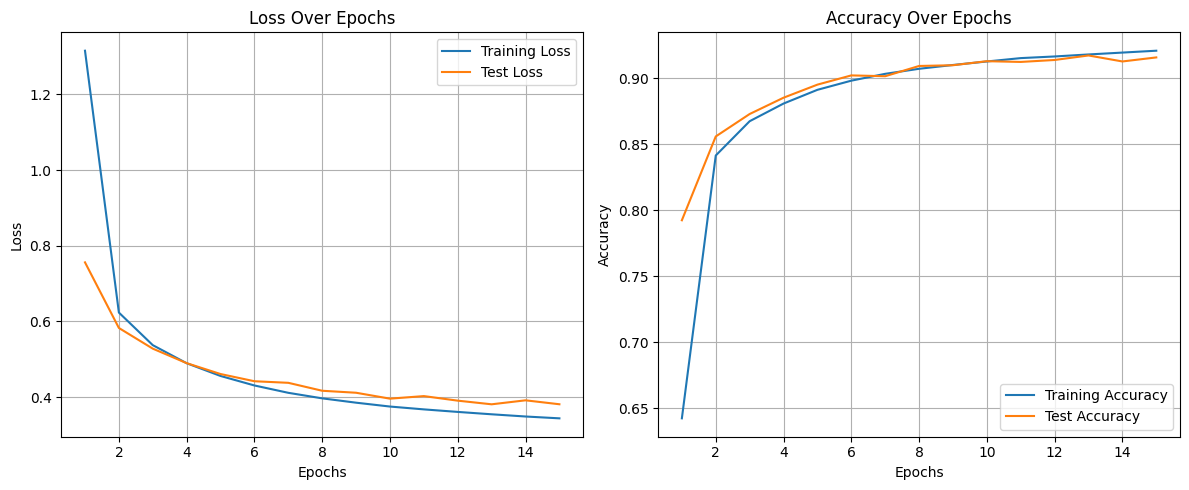

In [105]:
# Entrenar el modelo
num_epochs = 15
train_losses = []
train_accuracies = []
test_losses = []
test_accuracies = []

for epoch in range(num_epochs):
    # Entrenamiento
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels.view(-1))
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels.view(-1)).sum().item()

    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total
    train_losses.append(epoch_loss)
    train_accuracies.append(epoch_accuracy)

    # Evaluación en el conjunto de validación
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in validation_loader:
            outputs = model(images)
            loss = criterion(outputs, labels.view(-1))

            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels.view(-1)).sum().item()

    epoch_loss = running_loss / len(validation_loader)
    epoch_accuracy = correct / total
    test_losses.append(epoch_loss)
    test_accuracies.append(epoch_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_losses[-1]:.4f}, Train Acc: {train_accuracies[-1]:.4f}, Test Loss: {test_losses[-1]:.4f}, Test Acc: {test_accuracies[-1]:.4f}")

# Guardar el modelo entrenado
torch.save(model.state_dict(), 'simple_cnn_model.pth')

# Crear la gráfica de pérdida y precisión
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label='Training Loss')
plt.plot(range(1, num_epochs+1), test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label='Training Accuracy')
plt.plot(range(1, num_epochs+1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

In [106]:
def compare_letter_pairs(true_labels, predicted_labels):
    if len(true_labels) != len(predicted_labels):
        raise ValueError("Les llistes han de tenir la mateixa longitud")

    total_pairs = len(true_labels)
    same_letter_count = 0
    total_letters = 0

    for label1, label2 in zip(true_labels, predicted_labels):
        if label1 == label2:
            same_letter_count += 1

        total_letters += 1

    letter_percentage = (same_letter_count / total_letters) * 100

    return same_letter_count, letter_percentage

# Exemple d'ús amb les prediccions del model
true_labels = []
predicted_labels = []

with torch.no_grad():
    for images, labels in validation_generator:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        true_labels.extend(labels.cpu().numpy())
        predicted_labels.extend(predicted.cpu().numpy())

same_letter_count, letter_percentage = compare_letter_pairs(true_labels, predicted_labels)
print(f'Nombre de lletres correctes: {same_letter_count}')
print(f'Percentatge de lletres correctes: {letter_percentage}%')

Nombre de lletres correctes: 17922
Percentatge de lletres correctes: 91.59766942655627%
